In [2]:

import os
import kagglehub

data_path = kagglehub.dataset_download('sahilchambyal/solana-price-usd')

# List the files inside the downloaded data directory
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/sahilchambyal/solana-price-usd/versions/1/SOLUSD_1s_01NOV2024_to15NOV2024.csv
/root/.cache/kagglehub/datasets/sahilchambyal/solana-price-usd/versions/1/SOLUSD_1s_05NOV2024_to15NOV2024.csv
/root/.cache/kagglehub/datasets/sahilchambyal/solana-price-usd/versions/1/SOLUSD_1min_20AUG2020_to15NOV2024.csv


In [3]:
import pandas as pd
df = pd.read_csv(data_path + '/SOLUSD_1min_20AUG2020_to15NOV2024.csv')

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, callbacks

# Detect and initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()  # Default strategy

print("Number of devices: ", strategy.num_replicas_in_sync)


Running on TPU: 
Number of devices:  8


In [5]:
# Convert OpenTime and CloseTime to datetime if necessary
df['OpenTime'] = pd.to_datetime(df['OpenTime'], unit='ms')
df['CloseTime'] = pd.to_datetime(df['CloseTime'], unit='ms')

# Sort by OpenTime to ensure chronological order
df.sort_values('OpenTime', inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Drop unnecessary columns
df.drop(['Ignore'], axis=1, inplace=True)

# Handle missing values if any
df.isnull().sum()
# Assuming no missing values; if present, handle accordingly


,0
OpenTime,0
Open,0
High,0
Low,0
Close,0
Volume,0
CloseTime,0
QuoteAssetVolume,0
NumberOfTrades,0
TakerBuyBaseVolume,0


In [6]:
# Features to be used for training
features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'QuoteAssetVolume', 'NumberOfTrades',
            'TakerBuyBaseVolume', 'TakerBuyQuoteVolume']

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the features
scaled_data = scaler.fit_transform(df[features])

# Convert to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df.head()


,Open,High,Low,Close,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseVolume,TakerBuyQuoteVolume
0,0.007424,0.007339,0.007577,0.007492,0.001200,0.000075,0.000396,0.000157,0.000007
1,0.007382,0.007320,0.007541,0.007483,0.004161,0.000260,0.000506,0.002658,0.000116
2,0.007355,0.007308,0.007541,0.007474,0.000669,0.000042,0.000198,0.000035,0.000002
3,0.007356,0.007354,0.007550,0.007518,0.000936,0.000059,0.000242,0.000979,0.000043
4,0.007417,0.007329,0.007611,0.007493,0.000182,0.000011,0.000044,0.000000,0.000000


In [7]:
# Define sequence length
SEQ_LENGTH = 60  # Using 60 time steps

# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i][3])  # Assuming 'Close' is the target
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_data, SEQ_LENGTH)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2228940, 60, 9)
y shape: (2228940,)


In [8]:
# Define train-test split ratio
TRAIN_SPLIT = 0.8
train_size = int(len(X) * TRAIN_SPLIT)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (1783152, 60, 9) (1783152,)
Testing set shape: (445788, 60, 9) (445788,)


In [9]:
with strategy.scope():
    model = models.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        layers.Dropout(0.2),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    # Display model summary
    model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           70656     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [10]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import callbacks

# Detect and initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()  # Default strategy

print("Number of devices: ", strategy.num_replicas_in_sync)

# Define the model within the strategy scope
with strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    # Define callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model_checkpoint = callbacks.ModelCheckpoint(
        '/kaggle/working/best_model.weights.h5',
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True
    )

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=8192,  # Adjust based on TPU memory
    validation_split=0.1,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)


Running on TPU: 
Number of devices:  8
Epoch 1/10
196/196 [==============================] - 44s 178ms/step - loss: 0.0022 - mae: 0.0220 - val_loss: 7.6299e-06 - val_mae: 0.0022
Epoch 2/10
196/196 [==============================] - 27s 138ms/step - loss: 7.2157e-04 - mae: 0.0138 - val_loss: 3.2913e-06 - val_mae: 0.0013
Epoch 3/10
196/196 [==============================] - 27s 138ms/step - loss: 6.3128e-04 - mae: 0.0125 - val_loss: 3.8311e-06 - val_mae: 0.0014
Epoch 4/10
196/196 [==============================] - 27s 138ms/step - loss: 5.6687e-04 - mae: 0.0116 - val_loss: 1.8298e-06 - val_mae: 8.7161e-04
Epoch 5/10
196/196 [==============================] - 27s 137ms/step - loss: 5.1223e-04 - mae: 0.0110 - val_loss: 1.0034e-05 - val_mae: 0.0025
Epoch 6/10
196/196 [==============================] - 27s 138ms/step - loss: 4.7441e-04 - mae: 0.0107 - val_loss: 1.0387e-05 - val_mae: 0.0025
Epoch 7/10
196/196 [==============================] - 27s 137ms/step - loss: 4.4721e-04 - mae: 0.0107 -

In [12]:
# Load the best model
model.load_weights('/kaggle/working/best_model.weights.h5')

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test MSE: {test_loss}, Test MAE: {test_mae}')


13931/13931 [==============================] - 145s 10ms/step - loss: 5.9102e-06 - mae: 0.0017
Test MSE: 5.910227173444582e-06, Test MAE: 0.001710975426249206


13931/13931 [==============================] - 144s 10ms/step


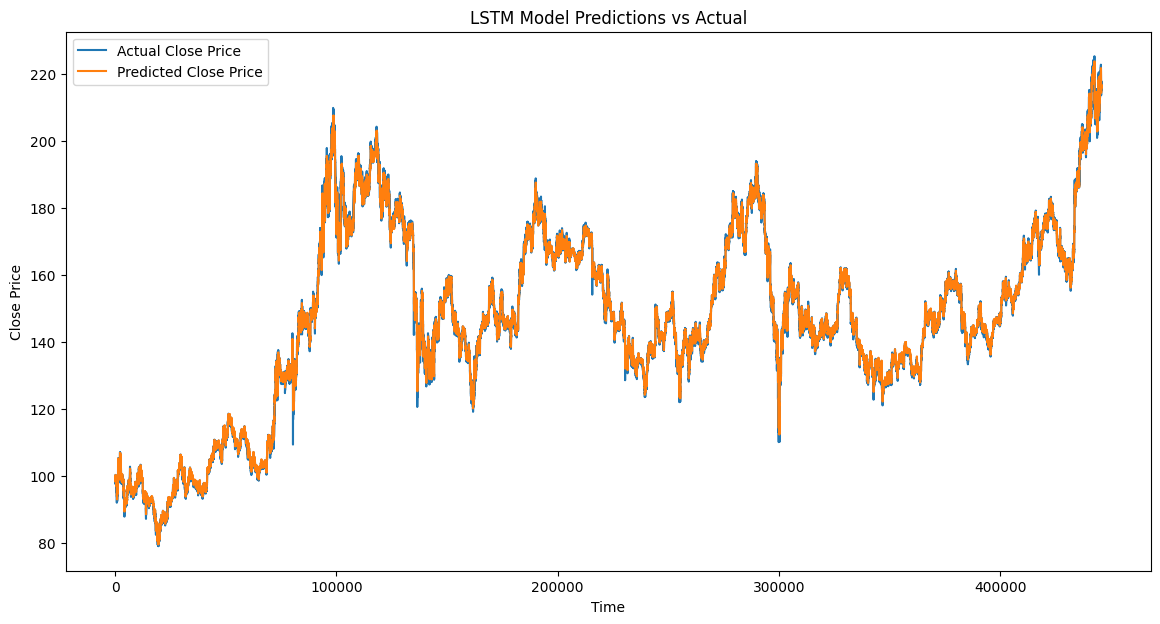

In [13]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
# Since we scaled all features, we'll inverse transform only the 'Close' column
# Create a scaler for 'Close' only
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]

predictions_inverse = close_scaler.inverse_transform(predictions)
y_test_inverse = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14,7))
plt.plot(y_test_inverse, label='Actual Close Price')
plt.plot(predictions_inverse, label='Predicted Close Price')
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()
